# GTZAN - Deep Learning

`Music Genre Classification Problem`. Experts have been trying for a long time to understand sound & what differentiates one from another. How to visualize sound. What makes one tone different from another.

We are going to analyze the features extracted from the GTZAN dataset and build different type of ensemble models to see how better we can differentiate one genre from another.

Our Datasets contains 10 genres:-
- Blues
- Classical
- Country
- Disco
- Hiphop
- Jazz
- Metal
- Pop
- Reggae
- Rock


# Reading & Understanding Data
## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

### Loading Dataset

In [4]:
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv'

### About the dataset

In [26]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of Positive and Negative samples


,index,label
0,blues,1000
1,pop,1000
2,metal,1000
3,jazz,1000
4,reggae,1000
5,disco,999
6,hiphop,998
7,classical,998
8,rock,998
9,country,997


# Data Visualization

In [27]:
audio_fp = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [28]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

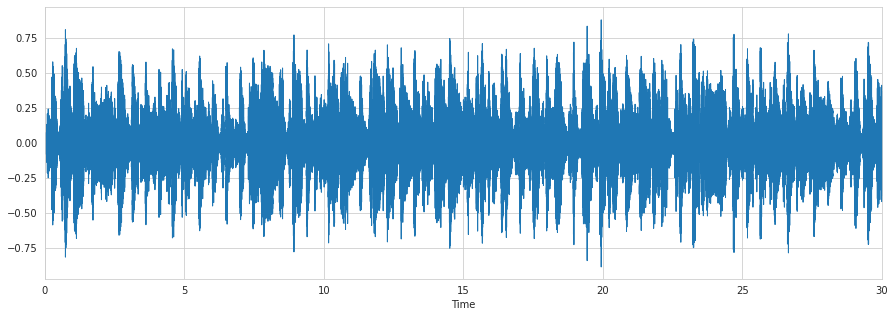

In [29]:
# plot sample file
plt.figure(figsize=(15,5))
lplt.waveplot(audio_data)
plt.show()

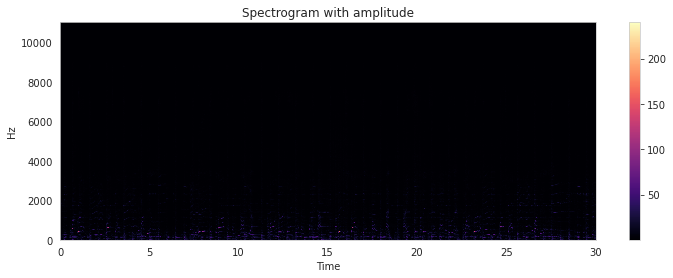

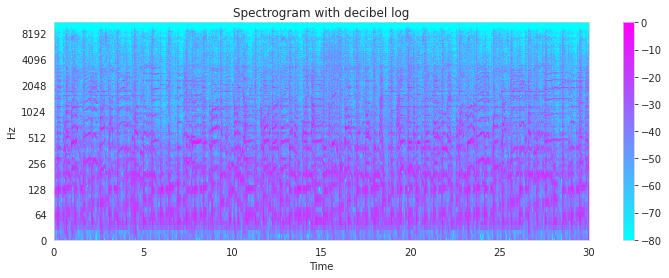

In [30]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

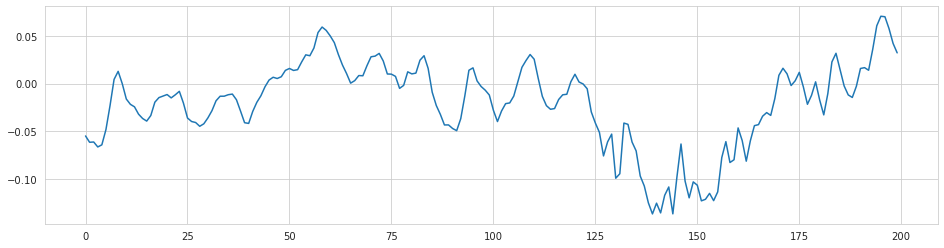

In [31]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

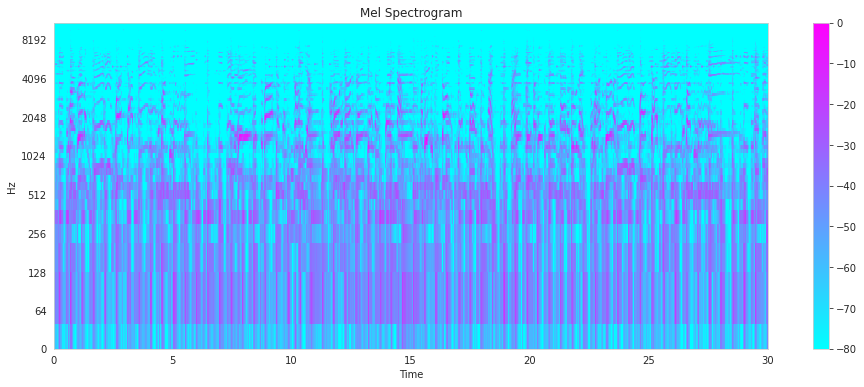

In [32]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

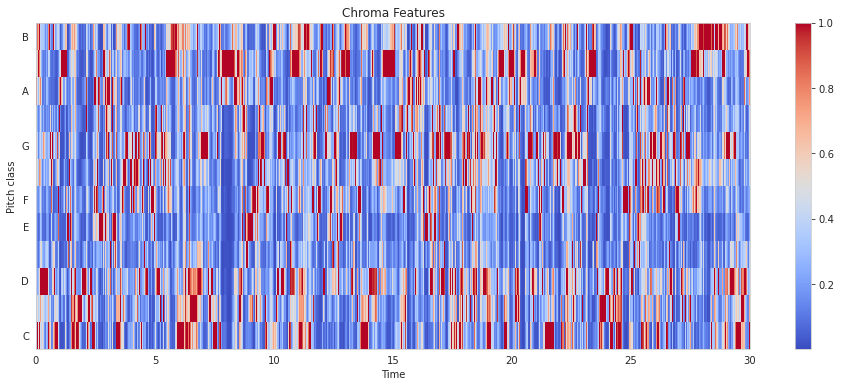

In [33]:
chroma = librosa.feature.chroma_stft(audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

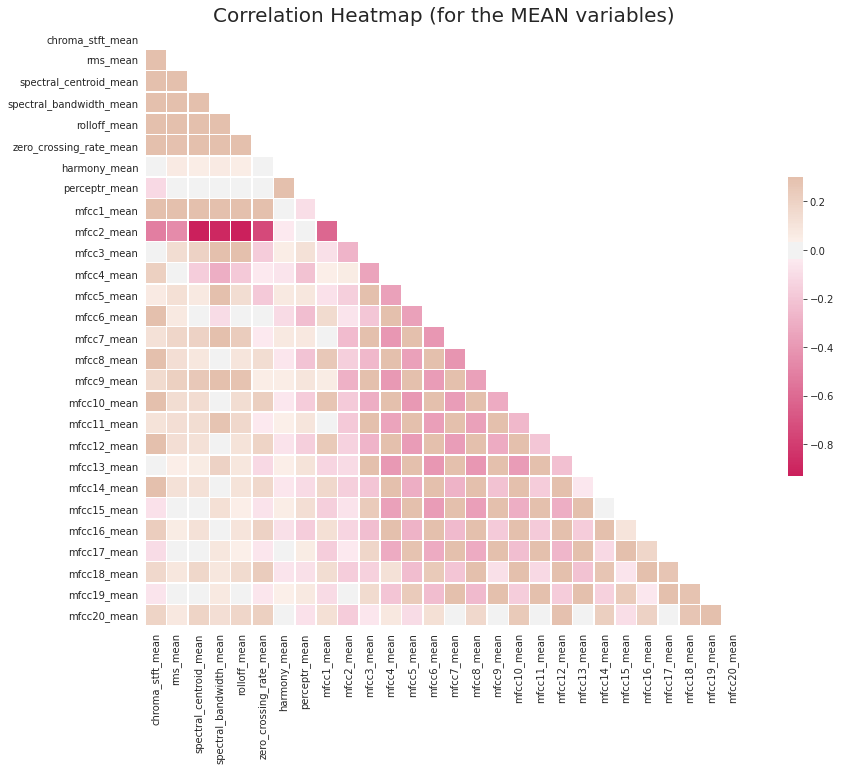

In [34]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr_Heatmap.png")

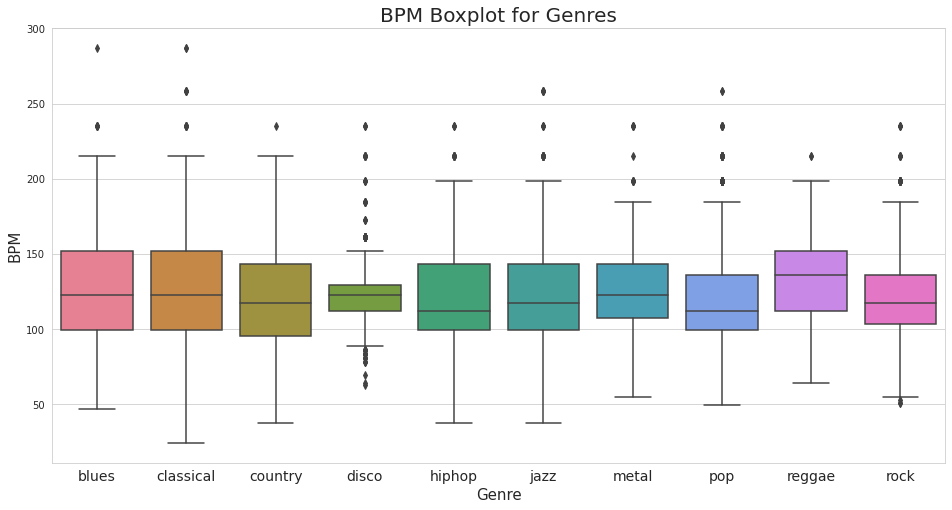

In [35]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

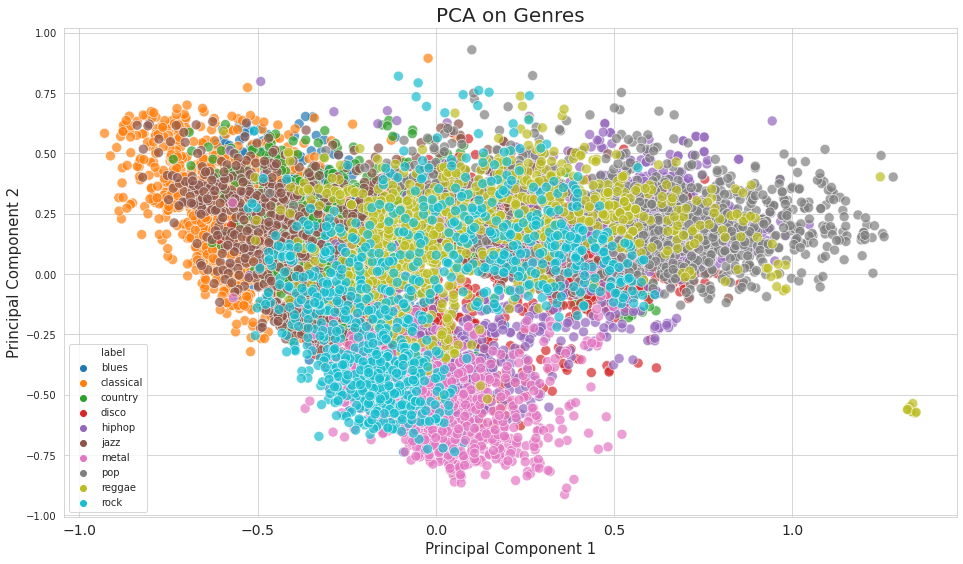

In [36]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

# Data Preparation

- Treat missing values.
- Outlier Treatment
- Define dummy variables for categorical variables.

## Missing Value Treatment

In [37]:
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


`No null values in the dataset`



`There are no categorical variable as such. Hence, Dummy variable creation is not needed.`

## Encode Genre Label

In [38]:
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [39]:
df.label = [label_index[l] for l in df.label]

# Split Train, Dev & Test Sets

In [40]:
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [41]:
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [42]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [43]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


## Scale the Features

In [44]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Pytorch 

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

In [58]:
class MusicGenreClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MusicGenreClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)

In [62]:
def train_model(model, epochs, optimizer, train_loader, dev_loader, accuracy_threshold=0.94):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        print(f'Epoch: {epoch}')
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)  
            loss.backward()
            optimizer.step()

In [63]:
def evaluate_model(model, test_loader):
    model.eval() 
    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() 

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += y_batch.size(0)
            correct_predictions += (predicted == y_batch).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

In [64]:
X_train_tensor = torch.Tensor(X_train.values)
y_train_tensor = torch.Tensor(y_train.values).long()
X_dev_tensor = torch.Tensor(X_dev.values)
y_dev_tensor = torch.Tensor(y_dev.values).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False)

In [65]:
model = MusicGenreClassifier(input_size=X_train.shape[1], num_classes=10)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

train_model(model, epochs=100, optimizer=optimizer, train_loader=train_loader, dev_loader=dev_loader)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99


In [67]:
test_loss, test_accuracy = evaluate_model(model, dev_loader)
print(f"The test Loss is: {test_loss}")
print(f"\nThe Best test Accuracy is: {test_accuracy * 100}%")

The test Loss is: 1.6273408085107803

The Best test Accuracy is: 83.67037411526795%


In [68]:
torch.save(model.state_dict(), 'genre_classifier_model.pth')

# Using the Model

In [11]:
import torch
import torch.nn as nn

class MusicGenreClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MusicGenreClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)
    
model = MusicGenreClassifier(input_size=57, num_classes=10)
model.load_state_dict(torch.load('genre_classifier_model.pth'))
model.eval()

MusicGenreClassifier(
  (network): Sequential(
    (0): Linear(in_features=57, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=64, out_features=10, bias=True)
    (16): Softmax(dim=1)
  )
)

In [20]:
import librosa
import numpy as np


import librosa
import numpy as np

def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    features = []
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend([np.mean(chroma_stft), np.var(chroma_stft)])
    rms = librosa.feature.rms(y=y)
    features.extend([np.mean(rms), np.var(rms)])
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.extend([np.mean(spec_centroid), np.var(spec_centroid)])
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features.extend([np.mean(spec_bandwidth), np.var(spec_bandwidth)])
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features.extend([np.mean(rolloff), np.var(rolloff)])
    zero_cross_rate = librosa.feature.zero_crossing_rate(y)
    features.extend([np.mean(zero_cross_rate), np.var(zero_cross_rate)])
    harmony = librosa.effects.harmonic(y)
    features.extend([np.mean(harmony), np.var(harmony)])
    percussive = librosa.effects.percussive(y)
    features.extend([np.mean(percussive), np.var(percussive)])
    tempo = librosa.beat.tempo(y=y, sr=sr, aggregate=None)
    features.append(np.mean(tempo))
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for mfcc in mfccs:
        features.extend([np.mean(mfcc), np.var(mfcc)])
    
    return np.array(features)

audio_path = 'example/example.mp3'
features = extract_features(audio_path)
print("Features extracted:", features)
print("Number of features extracted:", len(features))

feature_values = torch.tensor(features, dtype=torch.float32).unsqueeze(0)

print("Feature tensor shape:", feature_values.shape)
model.eval()
with torch.no_grad():
    outputs = model(feature_values)
    predicted_genre_index = outputs.argmax(dim=1).item()

genre_mapping = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop',
                 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
predicted_genre = genre_mapping[predicted_genre_index]
print(f"The predicted genre of the song is: {predicted_genre}")

Features extracted: [ 3.41001898e-01  9.10050347e-02  3.05773113e-02  3.36775527e-04
  1.89676062e+03  1.02601079e+06  2.41878992e+03  6.47822028e+05
  3.87179834e+03  5.94997901e+06  3.68420297e-02  6.98019821e-04
  1.00482062e-07  1.06661255e-03  6.60141222e-06  4.39931719e-05
  1.19853390e+02 -3.45525787e+02  6.88252100e+03  1.73048630e+02
  9.37815430e+02 -9.79666805e+00  9.00695679e+02  1.07630930e+01
  9.55421936e+02 -2.34606099e+00  5.27476807e+02  1.35980968e+01
  1.01569878e+02 -1.24966259e+01  7.79295273e+01 -1.05840540e+01
  6.14105072e+01 -5.20187044e+00  5.88319511e+01 -6.37918520e+00
  5.06162643e+01 -5.26624727e+00  4.24572754e+01 -7.25352287e+00
  4.73643723e+01 -7.21872663e+00  4.17366257e+01 -8.76614666e+00
  3.91763229e+01 -4.88048601e+00  4.18156281e+01 -5.78941441e+00
  4.24619408e+01 -6.07057095e+00  3.13279591e+01 -9.86004448e+00
  3.79078178e+01 -3.33805776e+00  5.11368942e+01 -4.22438383e+00
  5.62880669e+01]
Number of features extracted: 57
Feature tensor shap